N mode Gaussian WignerのPhoton Number Distribution は 2N variable Hermite Polynomialを使って計算できる。

arXiv:1903.02310 [quant-ph]

In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import strawberryfields as sf

## 2 variable Hemite Polynomial

In [510]:
mu = np.array([2, 2])
sigma = np.array([[1, 0.2], [0.2, 2]])

In [511]:
d = np.linalg.det(sigma)
T = np.trace(sigma)
R11 = 2 * (sigma[1, 1] - sigma[0, 0] - 2j * sigma[0, 1])
R12 = 1 - 4*d
R22 = 2 * (sigma[1, 1] - sigma[0, 0] + 2j * sigma[0, 1])
R = 1 / (1 + 2*T + 4*d) * np.array([[R11, R12], [R12, R22]])

y1 = np.sqrt(2) / (2*T - 4*d - 1) * ( (mu[0] - 1j * mu[1]) * (T - 1) + (sigma[1, 1] - sigma[0, 0] + 2j * sigma[0, 1]) * (mu[0] + 1j * mu[1]))
y2 = np.conj(y1)
y = np.array([y1, y2])
L = 1 + 2*T + 4*d
P0 = 2 / np.sqrt(L) * np.exp(-1 / L * (((2*sigma[0, 0] + 1) * mu[1]**2) + ((2*sigma[1, 1] + 1) * mu[0]**2) )) \
* np.exp(4 * sigma[0, 1] / L * mu[1] * mu[0])

print(P0)

0.07455510616671301


[1.00000000e+00+0.00000000e+00j 1.47514912e+00+0.00000000e+00j
 3.29721881e+00+0.00000000e+00j 9.71591099e+00-1.11022302e-16j
 3.54100786e+01+0.00000000e+00j 1.53577968e+02-1.99840144e-15j
 7.72014592e+02-6.52811138e-14j 4.41152231e+03-1.90958360e-13j
 2.82312872e+04-9.36140054e-13j 1.99938991e+05-2.61124455e-12j
 1.55201332e+06-9.35482802e-11j 1.30993390e+07-3.78725851e-09j
 1.19408576e+08+1.95495087e-08j 1.16885924e+09+3.71801729e-07j
 1.22259419e+10-2.63056991e-06j 1.36059048e+11-1.59754667e-05j
 1.60493485e+12-5.37426297e-04j 1.99996034e+13-3.46970672e-03j
 2.62498537e+14-5.29976517e-02j 3.61922299e+15+8.13596738e-01j
 5.22928473e+16-1.70359354e+01j]


/Users/ryunagai/.pyenv/versions/3.6.5/envs/StrawberyFields_0.11.1/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


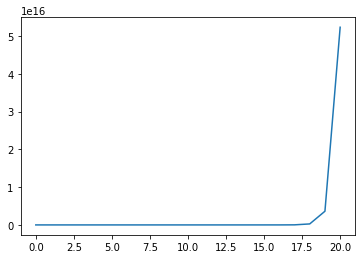

In [512]:
N = 20
H = np.zeros([N + 1, N + 1]) + 0j

for n1 in range(N+1):
    for n2 in range(N+1):
        for n3 in range(N+1):
            for n4 in range(N+1):
                for n5 in range(N+1):
                    N1 = n1 + 2 * n3 + n5
                    N2 = n2 + 2 * n4 + n5
                    if (N1==N2) and (N1 <= N):
                        C = np.dot(y, R[:, 0])**n1 * np.dot(y, R[:, 1])**n2 * (-R[0, 0] / 2)**(n3) * (-R[1, 1] / 2)**(n4) * (-R[0, 1])**n5
                        C = C / (np.prod(special.factorial([n1, n2, n3, n4, n5])))
                        H[N1, N2] += C * np.prod(special.factorial([N1, N2]))
print(np.diag(H))
plt.plot((np.diag(H)))

(0.9960069763865881-2.241790790556556e-17j)


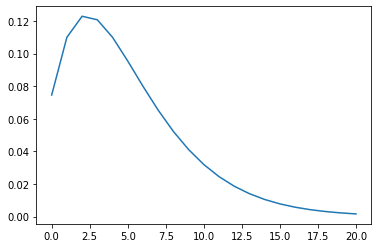

In [246]:
P = P0 * ((np.diag(H) / special.factorial([i for i in range(N + 1)])))
plt.plot(P)
print(np.sum(P))

## Xanadu Strawberry Fields

In [40]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *

# initialize engine and program objects
eng = sf.Engine(backend="gaussian")
gbs = sf.Program(4)

# define the linear interferometer
U = np.array([
 [ 0.219546940711-0.256534554457j, 0.611076853957+0.524178937791j,
    -0.102700187435+0.474478834685j,-0.027250232925+0.03729094623j],
 [ 0.451281863394+0.602582912475j, 0.456952590016+0.01230749109j,
    0.131625867435-0.450417744715j, 0.035283194078-0.053244267184j],
 [ 0.038710094355+0.492715562066j,-0.019212744068-0.321842852355j,
    -0.240776471286+0.524432833034j,-0.458388143039+0.329633367819j],
 [-0.156619083736+0.224568570065j, 0.109992223305-0.163750223027j,
    -0.421179844245+0.183644837982j, 0.818769184612+0.068015658737j]
])


with gbs.context as q:
    # prepare the input squeezed states
    S = Sgate(1)
    S | q[0]
    S | q[1]
    S | q[2]
    S | q[3]

    # linear interferometer
    Interferometer(U) | q
    # end circuit

# run the engine
results = eng.run(gbs)

# Fock states to measure at output
measure_states = [[0,0,0,0], [1,1,0,0], [0,1,0,1], [1,1,1,1], [2,0,0,0]]

# extract the probabilities of calculating several
# different Fock states at the output, and print them to the terminal
for i in measure_states:
    prob = results.state.fock_prob(i)
    print("|{}>: {}".format("".join(str(j) for j in i), prob))

|0000>: 0.17637844761413474
|1100>: 0.0685595637122451
|0101>: 0.002056097258972289
|1111>: 0.008342946399881954
|2000>: 0.010312945253440302


In [41]:
cov = results.state.cov()
cov
#results.state.means()

array([[ 4.24887913, -2.63913015, -0.24646106, -0.3900475 , -1.55408783,
        -1.36025373,  1.09776694,  0.51845556],
       [-2.63913015,  4.26247566,  0.28417147,  0.34068907, -1.36025373,
        -1.56965749, -1.13118959, -0.38509899],
       [-0.24646106,  0.28417147,  5.43083728,  2.04612871,  1.09776694,
        -1.13118959,  1.82876866,  0.46101578],
       [-0.3900475 ,  0.34068907,  2.04612871,  0.97384172,  0.51845556,
        -0.38509899,  0.46101578,  0.54287828],
       [-1.55408783, -1.36025373,  1.09776694,  0.51845556,  3.27551226,
         2.63913015,  0.24646106,  0.3900475 ],
       [-1.36025373, -1.56965749, -1.13118959, -0.38509899,  2.63913015,
         3.26191572, -0.28417147, -0.34068907],
       [ 1.09776694, -1.13118959,  1.82876866,  0.46101578,  0.24646106,
        -0.28417147,  2.09355411, -2.04612871],
       [ 0.51845556, -0.38509899,  0.46101578,  0.54287828,  0.3900475 ,
        -0.34068907, -2.04612871,  6.55054966]])

In [8]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *

# initialize engine and program objects
eng = sf.Engine(backend="gaussian")
gbs = sf.Program(1)

with gbs.context as q:
    # prepare the input squeezed states
    S = Sgate(1)
    D = Dgate(1)
    S | q[0]
    D | q[0]

# run the engine
results = eng.run(gbs)

# Fock states to measure at output
measure_states = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

# extract the probabilities of calculating several
# different Fock states at the output, and print them to the terminal
total_prob = 0
for i in measure_states:
    prob = results.state.fock_prob(i)
    print("|{}>: {}".format("".join(str(j) for j in i), prob))
    total_prob += prob
print("total prob =", total_prob)

|0>: 0.1113168113828589
|1>: 0.34543988421225996
|2>: 0.30518524364851035
|3>: 0.03856434008920449
|4>: 0.036632136326058724
|5>: 0.08097082578290182
|6>: 0.0051232383329247455
|7>: 0.023403289161592913
|8>: 0.021395268510089063
|9>: 0.000573900365801342
total prob = 0.9686049378122025


Returns the $\langle i | \rho | j \rangle$ element of the density matrix
of a Gaussian state defined by covariance matrix cov.

Args:
    mu (array): length-$2N$ quadrature displacement vector  
    cov (array): length-$2N$ covariance matrix  
    i (list): list of density matrix rows  
    j (list): list of density matrix columns  
    include_prefactor (bool): if "True", the prefactor is automatically calculated  
        used to scale the result.  
    tol (float): tolerance for determining if displacement is negligible  
    hbar (float): the value of $\hbar$ in the commutation  
        relation $[x,p]=i\hbar$.  

Returns:
    complex: the density matrix element

From StrawberryFields  
StrawberyFields_0.11.1/lib/python3.6/site-packages/hafnian/quantum.py  
density_matrix

In [277]:
if post_select is None:
        post_select = {}

    N = len(mu) // 2 # Number of Mode
    M = N - len(post_select)

    rho = np.zeros([cutoff] * (2 * M), dtype=np.complex128) # 2M x 2M Matrix of Fock density matrices

    for idx in product(range(cutoff), repeat=2 * M): # runs over all elements in rho
        el = []

        counter = count(0)
        modes = (np.arange(2 * N) % N).tolist() # [0, 1, ..., N, 0, 1, ..., N] : rows, columns (逆？)
        el = [post_select[i] if i in post_select else idx[next(counter)] for i in modes]
        # post selectされているモードだけインデックス(光子数)を変える

        el = np.array(el).reshape(2, -1) # rowとcolumnに分ける
        el0 = el[0].tolist() #rows
        el1 = el[1].tolist() # columns

        sf_idx = np.array(idx).reshape(2, -1) # rowとcolumnに分ける
        sf_el = tuple(sf_idx[::-1].T.flatten()) # row_0, col_0, row_1, col_1, ...といった順に変えてる？

        rho[sf_el] = density_matrix_element(mu, cov, el0, el1, include_prefactor=False, hbar=hbar)

    rho *= prefactor(mu, cov, hbar=hbar)

    if normalize:
        # construct the standard 2D density matrix, and take the trace
        new_ax = np.arange(2 * M).reshape([M, 2]).T.flatten()
        tr = np.trace(rho.transpose(new_ax).reshape([cutoff ** M, cutoff ** M])).real
        # renormalize
        rho /= tr

    return rho

'0.11.1'

In [351]:
np.zeros([4, 4]   * 3).shape

(4, 4, 4, 4, 4, 4)

In [360]:
from itertools import product, count

In [337]:
for i in product([[1, 2], [3, 4]], [[1, 2], [3, 4]]): # 1次元ベクトル同士の直積
    print(i, '\n')
for i in product([1, 2], repeat = 4): # 1次元ベクトル同士の直積
    print(i)

([1, 2], [1, 2]) 

([1, 2], [3, 4]) 

([3, 4], [1, 2]) 

([3, 4], [3, 4]) 

(1, 1, 1, 1)
(1, 1, 1, 2)
(1, 1, 2, 1)
(1, 1, 2, 2)
(1, 2, 1, 1)
(1, 2, 1, 2)
(1, 2, 2, 1)
(1, 2, 2, 2)
(2, 1, 1, 1)
(2, 1, 1, 2)
(2, 1, 2, 1)
(2, 1, 2, 2)
(2, 2, 1, 1)
(2, 2, 1, 2)
(2, 2, 2, 1)
(2, 2, 2, 2)


In [373]:
N = 2
idx = (1, 1, 2, 1)
post_select = {}
counter = count(0)
modes = (np.arange(2 * N) % N).tolist() # [0, 1, ..., N, 0, 1, ..., N]
el = [post_select[i] if i in post_select else idx[next(counter)] for i in modes]
el = np.array(el).reshape(2, -1)
print(el)
sf_idx = np.array(idx).reshape(2, -1)
print(sf_idx)
print(sf_idx[::-1])
tuple(sf_idx[::-1].T.flatten())

[[1 1]
 [2 1]]
[[1 1]
 [2 1]]
[[2 1]
 [1 1]]


(2, 1, 1, 1)

In [381]:
sf_idx = np.array([1, 2, 3, 4, 5, 6]).reshape(2, -1) # Element: rho1_11, rho2_22, rho3_33
print(sf_idx)
sf_idx[::-1].T.flatten()

[[1 2 3]
 [4 5 6]]


array([4, 1, 5, 2, 6, 3])

From StrawberryFields  
StrawberyFields_0.11.1/lib/python3.6/site-packages/hafnian/quantum.py  
density_matrix_element

In [382]:
rpt = i + j # i: row photonNum of modes, j: column photonNum of modes

    beta = Beta(mu, hbar=hbar) # (x, p) to (a, a_dagger)
    A = Amat(cov, hbar=hbar) # convert to A matrix in the paper
    if np.linalg.norm(beta) < tol:
        # no displacement
        if np.prod([k + 1 for k in rpt]) ** (1 / len(rpt)) < 3:
            A_rpt = reduction(A, rpt)
            haf = hafnian(A_rpt)
        else:
            haf = hafnian_repeated(A, rpt)
    else:
        # replace the diagonal of A with gamma
        # gamma = X @ np.linalg.inv(Q).conj() @ beta
        gamma = beta.conj() - A @ beta

        if np.prod([k + 1 for k in rpt]) ** (1 / len(rpt)) < 3:
            A_rpt = reduction(A, rpt)
            np.fill_diagonal(A_rpt, reduction(gamma, rpt))
            haf = hafnian(A_rpt, loop=True)
        else:
            haf = hafnian_repeated(A, rpt, mu=gamma, loop=True)

    if include_prefactor:
        haf *= prefactor(mu, cov, hbar=2)

    return haf / np.sqrt(np.prod(fac(rpt)))

IndentationError: unexpected indent (<ipython-input-382-043ab6dd919d>, line 3)